In [88]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols as s
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

graph_path = Path("../images/").resolve()
data_path = Path("../data/").resolve()

plt.style.use("./report.mplstyle")

Variabili

In [89]:
wave_length = 650 / 10**9

slit_name = 0.08
slit = slit_name / 10**3
slit_pos = 4 / 10**2

sensor_name = 1.5
sensor = sensor_name / 10**3
sensor_pos = 102.5 / 10**2

distance = sensor_pos - slit_pos

Load data

In [90]:
dfs = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(sensor_name) in file
]
print(len(dfs))

# Scelti mettendo lo 0 a metà tra i primi minimi
dfs[0].y += 0.098
dfs[1].y += 0.0962
dfs[2].y += 0.0982

3


Center sets on 0

(-0.7189109830000001, 15.869896703)

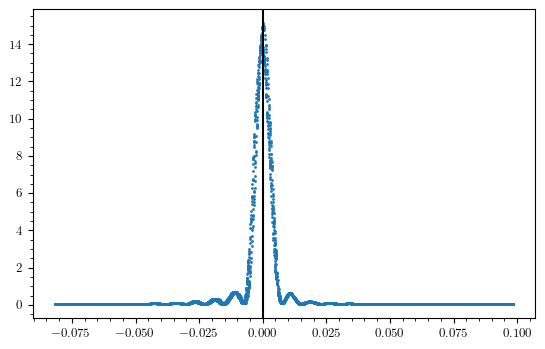

In [100]:
fig, ax = plt.subplots(1, 1)

df = dfs[2]
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Find minimums

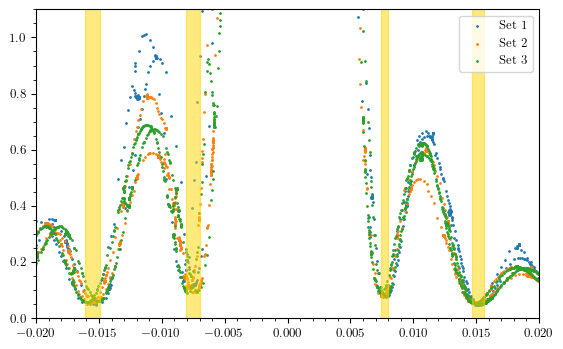

In [97]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

ylim = ax.get_ylim()
ax.fill_betweenx(ylim, [-0.0161]*2, [-0.0149]*2, color="gold", alpha=0.5)
ax.fill_betweenx(ylim, [-0.0081]*2, [-0.0070]*2, color="gold", alpha=0.5)
ax.fill_betweenx(ylim, [0.0074]*2, [0.0080]*2, color="gold", alpha=0.5)
ax.fill_betweenx(ylim, [0.0147]*2, [0.0156]*2, color="gold", alpha=0.5)
ax.set_ylim(0, 1.1)
ax.set_xlim(-0.02, 0.02)

ax.legend()

Fit

In [93]:
I_expr = s('I_0') * sp.Pow( sp.sinc(
    sp.pi * s('a') / s(r'\lambda') * s('y')/s('L')
), 2) + s('c')

I_fit = sp.lambdify(
    [s('y'), s('I_0'), s('a'), s('c')],
    I_expr.evalf(
        subs = {
            s(r'\lambda'): wave_length,
            s('L'): distance,
        }
    )
)

I_expr

I_0*sinc(pi*a*y/(L*\lambda))**2 + c

Rumore e picco

In [94]:
I_max = 1
I_min = 1

for df in dfs:
    I_min = df.I.min() if df.I.min() < I_min else I_min
    I_max = df.I.max() if df.I.max() > I_max else I_max

I_max, I_min

(15.47966003, 0.03265381)

In [95]:
I_fitted, a_fitted, c_fitted = 0, 0, 0
for df in dfs:
    popt, pcov = curve_fit(I_fit, df.y, df.I, [I_max, slit, I_min])
    print(popt)
    I_fitted += popt[0]
    a_fitted += popt[1]
    c_fitted += popt[2]

I_fitted /= len(dfs)
a_fitted /= len(dfs)
c_fitted /= len(dfs)

print(I_fitted)
print(a_fitted)
print(c_fitted)

[1.49764346e+01 7.89006844e-05 3.59030420e-02]
[1.25869828e+01 8.07645522e-05 4.32977455e-02]
[1.39608414e+01 8.36528575e-05 3.62137052e-02]
13.841419575732745
8.110603136018248e-05
0.038471497566317486


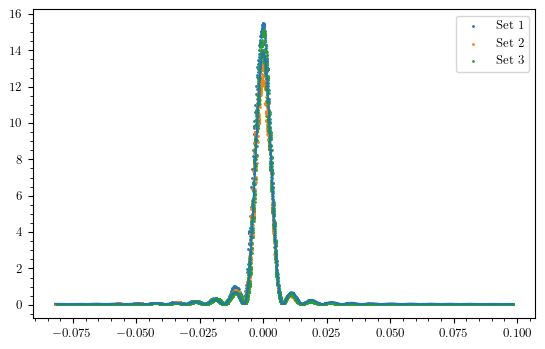

In [96]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

x = np.linspace(
    min([
        df.y.min()
        for df in dfs
    ]),
    max([
        df.y.max()
        for df in dfs
    ]),
    1000
)

ax.plot(x, I_fit(x, I_fitted, a_fitted + 0.15e-5, c_fitted))
# ax.plot(x, I_fit(x, I_fitted + 1.5, a_fitted - 0.4e-5, c_fitted))
# ax.plot(x, I_fit(x, I_fitted - 1.6, a_fitted + 0.7e-5, c_fitted))

ax.legend()